In [1]:
!pip install --quiet pandas numpy scikit-learn imbalanced-learn xgboost lightgbm shap matplotlib seaborn joblib

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import lightgbm as lgb
import joblib
import shap
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/Worksheet in Case Study question 2.csv')
print('Shape:', df.shape)
print('Columns:', df.columns.tolist()[:40])
df.head()

Shape: (1000, 39)
Columns: ['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported']


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,10/17/2014,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,6/27/2006,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,9/6/2000,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,5/25/1990,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,6/6/2014,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [4]:
label_candidates = ['fraud_reported', 'fraud', 'is_fraud', 'fraudulent']
label_col = None
for c in label_candidates:
    if c in df.columns:
        label_col = c
        break

if label_col is None:
    raise ValueError('No common label column found.')

print('Using label column:', label_col)

df[label_col] = df[label_col].astype(str).str.strip().str.lower().map(
    lambda x: 1 if x in ('y','yes','1','true','t','fraud','fraudulent') else 0)

print(df[label_col].value_counts())

Using label column: fraud_reported
fraud_reported
0    753
1    247
Name: count, dtype: int64


In [6]:
drop_cols = [c for c in ['policy_number','policy_id','claim_id','policy_no','id'] if c in df.columns]
if drop_cols:
    print('Dropping identifiers:', drop_cols)
    df = df.drop(columns=drop_cols)

X = df.drop(columns=[label_col])
y = df[label_col].astype(int)

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numeric cols (sample):', num_cols[:10])
print('Categorical cols (sample):', cat_cols[:10])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

print('Preprocessor ready')

Numeric cols (sample): ['months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss', 'incident_hour_of_the_day', 'number_of_vehicles_involved']
Categorical cols (sample): ['policy_bind_date', 'policy_state', 'policy_csl', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_date', 'incident_type']
Preprocessor ready


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print('Train shape (after preprocess):', X_train_prep.shape)
print('Test shape (after preprocess):', X_test_prep.shape)

Train shape (after preprocess): (800, 1784)
Test shape (after preprocess): (200, 1784)


In [8]:
print('Before SMOTE class distribution:\n', pd.Series(y_train).value_counts())
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_prep, y_train)
print('After SMOTE class distribution:\n', pd.Series(y_train_res).value_counts())

Before SMOTE class distribution:
 fraud_reported
0    602
1    198
Name: count, dtype: int64
After SMOTE class distribution:
 fraud_reported
0    602
1    602
Name: count, dtype: int64


In [9]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1,
                    n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8)
xgb.fit(X_train_res, y_train_res)
print('XGBoost trained')

lgb_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, n_estimators=200, learning_rate=0.05, num_leaves=31)
lgb_model.fit(X_train_res, y_train_res)
print('LightGBM trained')

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:28:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained
[LightGBM] [Info] Number of positive: 602, number of negative: 602
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6619
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 201
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM trained


--- XGBoost ---
ROC AUC: 0.8428
PR-AUC (avg precision): 0.575
F1: 0.66
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       151
           1       0.65      0.67      0.66        49

    accuracy                           0.83       200
   macro avg       0.77      0.78      0.77       200
weighted avg       0.83      0.83      0.83       200

Confusion matrix:
 [[133  18]
 [ 16  33]]


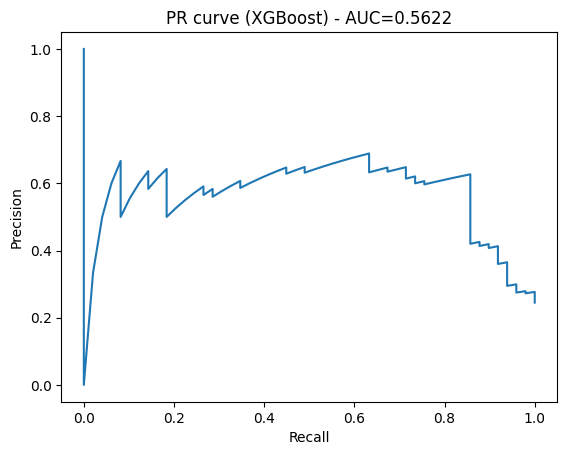

--- LightGBM ---
ROC AUC: 0.8307
PR-AUC (avg precision): 0.5718
F1: 0.6667
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       151
           1       0.66      0.67      0.67        49

    accuracy                           0.83       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.84      0.83      0.84       200

Confusion matrix:
 [[134  17]
 [ 16  33]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


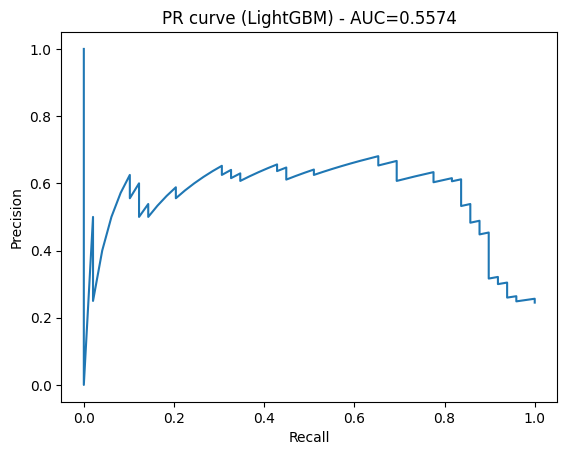

In [10]:
from sklearn.metrics import average_precision_score

def evaluate(model, Xp, yp, name='model'):
    probs = model.predict_proba(Xp)[:,1]
    preds = (probs >= 0.5).astype(int)
    roc = roc_auc_score(yp, probs)
    pr = average_precision_score(yp, probs)
    f1 = f1_score(yp, preds)
    print(f'--- {name} ---')
    print('ROC AUC:', round(roc,4))
    print('PR-AUC (avg precision):', round(pr,4))
    print('F1:', round(f1,4))
    print(classification_report(yp, preds))
    print('Confusion matrix:\n', confusion_matrix(yp, preds))

    precision, recall, _ = precision_recall_curve(yp, probs)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR curve ({name}) - AUC={pr_auc:.4f}')
    plt.show()

evaluate(xgb, X_test_prep, y_test, 'XGBoost')
evaluate(lgb_model, X_test_prep, y_test, 'LightGBM')

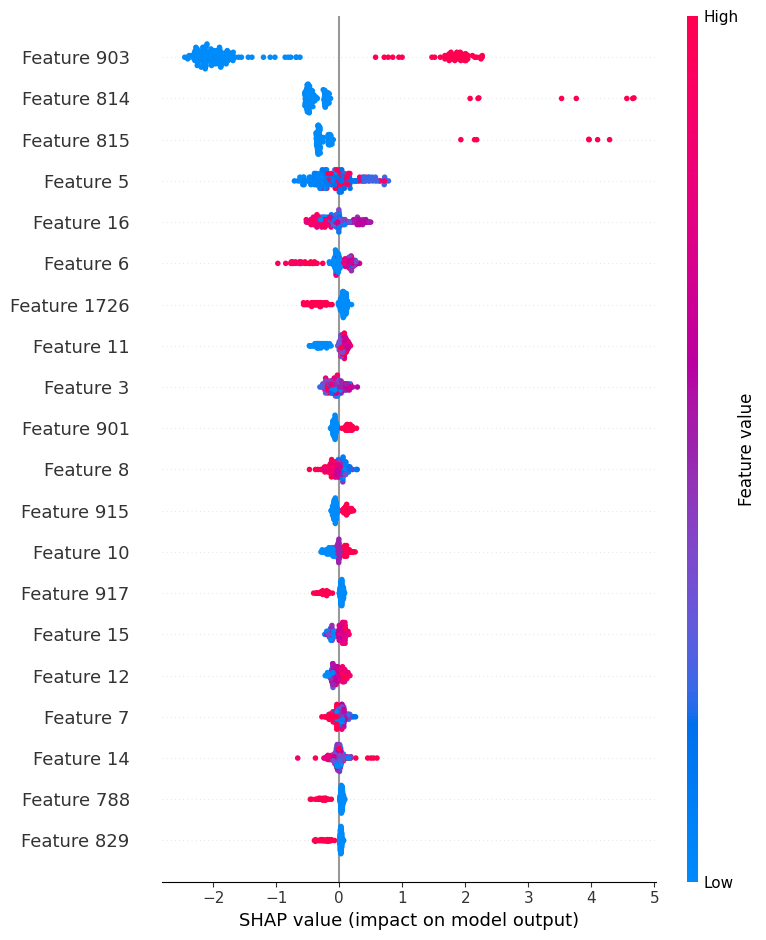

In [11]:
explainer = shap.TreeExplainer(xgb)
X_test_sample = X_test_prep[:500] if X_test_prep.shape[0] > 500 else X_test_prep
shap_values = explainer.shap_values(X_test_sample)

shap.summary_plot(shap_values, X_test_sample)

In [12]:
joblib.dump(preprocessor, 'preprocessor.joblib')
joblib.dump(xgb, 'xgb_model.joblib')
joblib.dump(lgb_model, 'lgb_model.joblib')

['lgb_model.joblib']